### Improve performance on the leaderboard -> Goal is >95%

In [1]:
import os
import tensorflow as tf
import PIL
import pathlib
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
# from collections import counter
import pandas as pd
import numpy as np

In [2]:
training_path = r'D:\kaggle\paddy_doctor_competition\train_images'
testing_path = r'D:\kaggle\paddy_doctor_competition\test_images'

# for notebook
# training_path = r'C:\data\paddy_doctor_competition\train_images'
# testing_path = r'C:\data\paddy_doctor_competition\test_images'

batch_size = 48
img_dim_h = 224 # 256, 352
img_dim_w = 224 # 256, 256

origin_dim_h = 224  # 640
origin_dim_w = 224  # 480

In [3]:
image_count = len(list(pathlib.Path(training_path).glob('*/*.jpg')))
ims = list(pathlib.Path(training_path).glob('*/*.jpg'))

In [4]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(25):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    im = cv2.imread(str(ims[i]))
    plt.imshow(im)
    plt.title('Image')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002019C446D30> (for post_execute):


KeyboardInterrupt: 

In [ ]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    training_path,
    # labels='inferred',
    label_mode='categorical',
    # class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(origin_dim_h, origin_dim_w),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    # interpolation='bilinear',
    # follow_links=False,
    crop_to_aspect_ratio=True,
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [ ]:
val_gen = tf.keras.utils.image_dataset_from_directory(
    training_path,
    # labels='inferred',
    label_mode='categorical',
    # class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(origin_dim_h, origin_dim_w),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    # interpolation='bilinear',
    # follow_links=False,
    crop_to_aspect_ratio=True,
)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 192, 3)


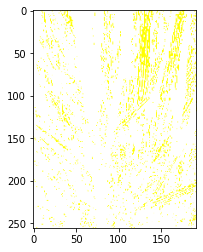

In [ ]:
for data in train_gen:
    x = data[0][0]
    print(x.shape)
    plt.imshow(x)

    break

In [ ]:
base_model = tf.keras.applications.convnext.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    input_shape=(origin_dim_h, origin_dim_w, 3),
)

base_model.trainable = False

In [ ]:
prediction_layer = tf.keras.layers.Dense(10, activation = "softmax")
preprocessing_layer_pad = tf.keras.layers.ZeroPadding2D(padding=(0, 32), data_format=None)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


inputs = tf.keras.Input((origin_dim_h, origin_dim_w, 3))
x = data_augmentation(inputs)
# x = data_augmentation(inputs)
# crop image
# tf.keras.layers.CenterCrop(
    # height, width, **kwargs
# )

# x = inputs
# x = preprocessing_layer_pad(inputs)
# x = tf.keras.layers.ZeroPadding2D(padding=(0, 32), data_format=None, input_shape=(256, 192, 3))(x)
# x = ZeroPadding2D((0, 32), input_shape=(256, 192, 3))(inputs)

x = tf.keras.applications.convnext.preprocess_input(x)
# x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
# x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = prediction_layer(x)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.layers[1].input_shape

(None, 256, 192, 3)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 192, 3)       0         
                                                                 
 convnext_small (Functional)  (None, 8, 6, 768)        49454688  
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4718720   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512 

In [ ]:
model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  # optimizer=tf.keras.optimizers.RMSprop(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, mode='auto', restore_best_weights=True)

In [ ]:
model_history = model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[early_stop])

Epoch 1/100
261/261 [==============================] - 137s 480ms/step - loss: 1.5781 - accuracy: 0.4705 - val_loss: 1.3822 - val_accuracy: 0.5070
Epoch 2/100
261/261 [==============================] - 124s 474ms/step - loss: 1.1172 - accuracy: 0.6252 - val_loss: 1.1063 - val_accuracy: 0.5954
Epoch 3/100
261/261 [==============================] - 120s 461ms/step - loss: 0.9401 - accuracy: 0.6877 - val_loss: 0.8489 - val_accuracy: 0.7165
Epoch 4/100
261/261 [==============================] - 119s 457ms/step - loss: 0.8248 - accuracy: 0.7236 - val_loss: 0.6724 - val_accuracy: 0.7785
Epoch 5/100
261/261 [==============================] - 119s 455ms/step - loss: 0.7938 - accuracy: 0.7311 - val_loss: 0.8442 - val_accuracy: 0.7184
Epoch 6/100
261/261 [==============================] - 119s 455ms/step - loss: 0.7289 - accuracy: 0.7618 - val_loss: 0.7068 - val_accuracy: 0.7765
Epoch 7/100
261/261 [==============================] - 119s 458ms/step - loss: 0.6808 - accuracy: 0.7792 - val_loss: 0

KeyboardInterrupt: 

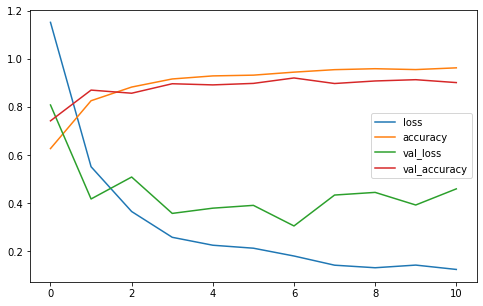

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
model_path = r'C:\data\paddy_doctor_competition\models\model.h5'
# model.save(r'C:\data\paddy_doctor_competition\models\model.h5')

In [ ]:
model = tf.keras.models.load_model(model_path)

### upload submission

In [ ]:
testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    # seed = 48,
    labels = None,
    shuffle = False
)

Found 3469 files belonging to 1 classes.


In [ ]:
predictions = model.predict(testing_data)
predictions.shape

109/109 [==============================] - 30s 234ms/step


(3469, 10)

In [ ]:
subm_path = r'D:\kaggle\paddy_doctor_competition\sample_submission.csv'
# subm_path = r'C:\data\paddy_doctor_competition\sample_submission.csv'

# ss = pd.read_csv(r'D:\kaggle\paddy_doctor_competition\sample_submission.csv')
ss = pd.read_csv(subm_path)

ss['label'] = np.argmax(predictions, axis=-1)
ss['label'] = ss['label'].replace([0,1,2,3,4,5,6,7,8,9], train_gen.class_names)
# ss['label'] = ss['label'].replace(labels_int, labels_str)
ss.to_csv("subm.csv",index=False)
ss.head()

,image_id,label
0,200001.jpg,blast
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast


In [ ]:
!pip install kaggle

In [ ]:
comp = 'paddy-disease-classification'

In [ ]:
from kaggle import api

api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 73.3k/73.3k [00:01<00:00, 37.9kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification